In [ ]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

# Load dataset from Google Drive
file_path = '/content/drive/MyDrive/amazon_reviews.csv'
df = pd.read_csv(file_path)

# Preview the data
df.head()


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0


In [ ]:
# Convert rating (overall) to sentiment label
def convert_sentiment(score):
    if score <= 2:
        return 0  # Negative
    elif score == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

# Apply the conversion
df['label'] = df['overall'].apply(convert_sentiment)

# Keep only the necessary columns and drop any empty review texts
df = df[['reviewText', 'label']].dropna()
df = df[df['reviewText'].str.strip() != '']

# Check the distribution
df['label'].value_counts()


,count
label,
2,4448
0,324
1,142


In [ ]:
from sklearn.utils import resample

df_majority = df[df.label == 2]
df_minority_0 = df[df.label == 0]
df_minority_1 = df[df.label == 1]

df_minority_0_upsampled = resample(df_minority_0, replace=True, n_samples=1000, random_state=42)
df_minority_1_upsampled = resample(df_minority_1, replace=True, n_samples=1000, random_state=42)

df_balanced = pd.concat([df_majority, df_minority_0_upsampled, df_minority_1_upsampled])


In [ ]:
df_balanced['label'].value_counts()


,count
label,
2,4448
0,1000
1,1000


In [ ]:
# Save to a new CSV file
df.to_csv('/content/drive/MyDrive/amazon_cleaned_reviews.csv', index=False)

print("✅ File saved as 'amazon_cleaned_reviews.csv' in your Google Drive.")


✅ File saved as 'amazon_cleaned_reviews.csv' in your Google Drive.


In [ ]:
train_texts_temp, test_texts, train_labels_temp, test_labels = train_test_split(
    df_balanced['reviewText'].tolist(),
    df_balanced['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_balanced['label']
)


In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts_temp,
    train_labels_temp,
    test_size=0.2,  # 20% of 80% = 16% overall
    random_state=42,
    stratify=train_labels_temp
)


In [ ]:
# Create DataFrames
train_df = pd.DataFrame({'reviewText': train_texts, 'label': train_labels})
val_df = pd.DataFrame({'reviewText': val_texts, 'label': val_labels})
test_df = pd.DataFrame({'reviewText': test_texts, 'label': test_labels})

# Save to Google Drive
train_df.to_csv('/content/drive/MyDrive/amazon_train_split.csv', index=False)
val_df.to_csv('/content/drive/MyDrive/amazon_validation_split.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/amazon_test_split.csv', index=False)

print("✅ Train, validation, and test datasets saved to Google Drive.")


✅ Train, validation, and test datasets saved to Google Drive.


In [ ]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)



In [ ]:
assert len(train_encodings['input_ids']) == len(train_labels), "Mismatch between tokenized texts and labels"
assert len(val_encodings['input_ids']) == len(val_labels), "Mismatch between tokenized texts and labels"
assert len(test_encodings['input_ids']) == len(test_labels), "Mismatch between tokenized texts and labels"


In [ ]:
import pandas as pd
import torch # Import torch for converting lists to tensors if needed later

# Convert tokenized data and labels into a dictionary for the training set
train_data = {key: train_encodings[key] for key in train_encodings.keys()}
train_data['label'] = train_labels

# Create the DataFrame from the dictionary
train_df = pd.DataFrame(train_data)

# Convert tokenized data and labels into a dictionary for the validation set
val_data = {key: val_encodings[key] for key in val_encodings.keys()}
val_data['label'] = val_labels

# Create the DataFrame from the dictionary
val_df = pd.DataFrame(val_data)

# Convert tokenized data and labels into a dictionary for the test set
test_data = {key: test_encodings[key] for key in test_encodings.keys()}
test_data['label'] = test_labels

# Create the DataFrame from the dictionary
test_df = pd.DataFrame(test_data)

# You can optionally convert the columns containing token IDs to PyTorch tensors
# if you plan to use the DataFrames directly with PyTorch DataLoader later.
# For now, keeping them as lists within the DataFrame is also fine.
# Example for one column:
# train_df['input_ids'] = train_df['input_ids'].apply(torch.tensor)

print("DataFrames created with tokenized data and labels.")

DataFrames created with tokenized data and labels.


In [ ]:
# Save training data to CSV
train_df.to_csv('/content/drive/MyDrive/tokenized_train.csv', index=False)

# Save validation data to CSV
val_df.to_csv('/content/drive/MyDrive/tokenized_val.csv', index=False)

# Save test data to CSV
test_df.to_csv('/content/drive/MyDrive/tokenized_test.csv', index=False)

print("Tokenized datasets have been saved to CSV files.")


Tokenized datasets have been saved to CSV files.


In [ ]:
import torch

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [ ]:
print(train_encodings.keys())


dict_keys(['input_ids', 'attention_mask'])


In [ ]:
import pandas as pd

# Check for missing values
print(df.isnull().sum())


reviewText    0
label         0
dtype: int64


In [ ]:
!pip install --upgrade transformers


In [ ]:
import transformers
print(transformers.__version__)


4.51.3


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=2,
)


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,  # Reduced epochs for quicker training
    per_device_train_batch_size=50,
    gradient_accumulation_steps=2,
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=2,
    report_to="none",  # Disable all logging integrations
    eval_strategy="epoch",  # Updated parameter name
    save_strategy="epoch"   # Updated parameter name
)


In [ ]:
pip install --upgrade transformers


In [ ]:
import transformers
print(transformers.__version__)


4.51.3


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=50,
    gradient_accumulation_steps=2,
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=2,
    report_to="none"  # Disable all logging integrations
)


In [ ]:
pip install --upgrade huggingface_hub


In [ ]:
import huggingface_hub
print(huggingface_hub.__version__)


0.31.2


In [ ]:
# Assuming the initial Google Drive mounting (if needed) has been executed.
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, Trainer, RobertaForSequenceClassification, TrainingArguments
import transformers
import torch

# Load dataset from Google Drive
file_path = '/content/drive/MyDrive/amazon_reviews.csv'
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")
    # You might want to exit or handle this error appropriately
    exit()

# Convert rating (overall) to sentiment label
def convert_sentiment(score):
    if score <= 2:
        return 0  # Negative
    elif score == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

# Apply the conversion
df['label'] = df['overall'].apply(convert_sentiment)

# Keep only the necessary columns and drop any empty review texts
df = df[['reviewText', 'label']].dropna()
df = df[df['reviewText'].str.strip() != '']

# Check the distribution
print("Original label distribution:")
print(df['label'].value_counts())

# Upsample the minority classes to balance the dataset
df_majority = df[df.label == 2]
df_minority_0 = df[df.label == 0]
df_minority_1 = df[df.label == 1]

# Check if minority dataframes are empty before upsampling
if not df_minority_0.empty:
    df_minority_0_upsampled = resample(df_minority_0, replace=True, n_samples=1000, random_state=42)
else:
    df_minority_0_upsampled = pd.DataFrame(columns=df.columns) # Create empty df with same columns

if not df_minority_1.empty:
    df_minority_1_upsampled = resample(df_minority_1, replace=True, n_samples=1000, random_state=42)
else:
     df_minority_1_upsampled = pd.DataFrame(columns=df.columns) # Create empty df with same columns


df_balanced = pd.concat([df_majority, df_minority_0_upsampled, df_minority_1_upsampled])

# Check the distribution of the balanced dataset
print("\nBalanced label distribution:")
print(df_balanced['label'].value_counts())

# Perform the train/test/validation split
train_texts_temp, test_texts, train_labels_temp, test_labels = train_test_split(
    df_balanced['reviewText'].tolist(),
    df_balanced['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_balanced['label']
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts_temp,
    train_labels_temp,
    test_size=0.2,  # 20% of 80% = 16% overall
    random_state=42,
    stratify=train_labels_temp
)

# Perform the tokenization
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Define the CustomDataset class and creates the datasets
print("\nTransformers version:", transformers.__version__)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=50,
    gradient_accumulation_steps=2,
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=2,
    report_to="none"  # Disable all logging integrations
)

# Load the pre-trained RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# Create the datasets using the variables defined from splitting and tokenization
train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)
test_dataset = CustomDataset(test_encodings, test_labels) # Define test_dataset here

# Initialize and train the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model
trainer.train()

# Step 2: Get model predictions
predictions_output = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(predictions_output.predictions), dim=1)

# Step 3: Map numerical labels to strings (optional)
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
pred_labels = [label_map[label.item()] for label in preds]
true_labels = [label_map[label] for label in test_labels]

# Step 4: Create DataFrame with review text, true label, and prediction
df_preds = pd.DataFrame({
    "reviewText": test_texts,
    "true_label": true_labels,
    "predicted_label": pred_labels
})

# Step 5: Save to CSV in Google Drive
output_path = "/content/drive/MyDrive/amazon_reviews_predictions.csv"
df_preds.to_csv(output_path, index=False)

print(f"\n✅ Predictions saved to: {output_path}")

Mounted at /content/drive
Original label distribution:
label
2    4448
0     324
1     142
Name: count, dtype: int64

Balanced label distribution:
label
2    4448
0    1000
1    1000
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]


Transformers version: 4.51.3


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


(…)eb5afc8b2b397fe5e04beabb9b1ef355255ade81:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.546100
100,0.239400



✅ Predictions saved to: /content/drive/MyDrive/amazon_reviews_predictions.csv


In [3]:
!zip -r model_files.zip /path/to/model_folder/


	zip warning: name not matched: /path/to/model_folder/

zip error: Nothing to do! (try: zip -r model_files.zip . -i /path/to/model_folder/)


In [ ]:
from sklearn.metrics import classification_report

print("\n🔍 Classification Report:")
print(classification_report(test_labels, preds.numpy(), target_names=["Negative", "Neutral", "Positive"]))



🔍 Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.90      0.92       200
     Neutral       0.82      0.92      0.86       200
    Positive       0.98      0.96      0.97       890

    accuracy                           0.95      1290
   macro avg       0.91      0.93      0.92      1290
weighted avg       0.95      0.95      0.95      1290



In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [ ]:
# Load the predictions CSV file
pred_df = pd.read_csv('/content/drive/MyDrive/amazon_reviews_predictions.csv')

# Display the first few rows
pred_df.head()


,reviewText,true_label,predicted_label
0,i have this in my go pro hero 3 black. works...,Positive,Positive
1,What can I say? It works and was formatted for...,Positive,Positive
2,this item came on time nice works well they w...,Positive,Positive
3,I picked this up to slam into my s3 phone & it...,Positive,Positive
4,Works fine in a Samsung Galaxy Note 2 - no nee...,Positive,Positive


In [ ]:
# Get true and predicted labels
true_labels = pred_df['true_label']
predicted_labels = pred_df['predicted_label']

# Print classification metrics
print("Classification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=["Negative", "Neutral", "Positive"]))


Classification Report:

              precision    recall  f1-score   support

    Negative       0.94      0.90      0.92       200
     Neutral       0.82      0.92      0.86       200
    Positive       0.98      0.96      0.97       890

    accuracy                           0.95      1290
   macro avg       0.91      0.93      0.92      1290
weighted avg       0.95      0.95      0.95      1290



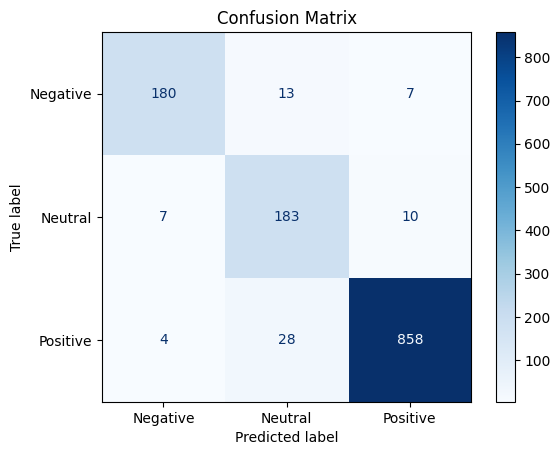

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Save the model and tokenizer
model_output_path = "/content/drive/MyDrive/roberta_sentiment_model"

model.save_pretrained(model_output_path)
tokenizer.save_pretrained(model_output_path)

print(f"Model and tokenizer saved to: {model_output_path}")


Model and tokenizer saved to: /content/drive/MyDrive/roberta_sentiment_model


In [ ]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

loaded_model = RobertaForSequenceClassification.from_pretrained(model_output_path)
loaded_tokenizer = RobertaTokenizer.from_pretrained(model_output_path)


In [ ]:
def predict_sentiment(text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokenize and move tensors to the correct device
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()

    return ["Negative", "Neutral", "Positive"][prediction]

# Example usage
sample_text = "I really loved this product."
print("Predicted Sentiment:", predict_sentiment(sample_text))


Predicted Sentiment: Positive


In [ ]:
print("Predicted Sentiment:", predict_sentiment("I really loved this product! Highly recommend."))
print("Predicted Sentiment:", predict_sentiment("This product is okay, not great."))
print("Predicted Sentiment:", predict_sentiment("Terrible quality, very disappointed."))


Predicted Sentiment: Positive
Predicted Sentiment: Neutral
Predicted Sentiment: Negative


In [ ]:
def predict_sentiments(texts):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    predictions = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        inputs = {key: val.to(device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            predicted_class = torch.argmax(outputs.logits, dim=1).item()

        label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
        predictions.append(label_map[predicted_class])

    return predictions


In [ ]:
# Assuming you have a DataFrame like df_balanced or df
df_to_predict = df_balanced.copy()

# Get predictions
df_to_predict['Predicted_Sentiment'] = predict_sentiments(df_to_predict['reviewText'].tolist())

# Save to Google Drive as CSV
output_path = '/content/drive/MyDrive/amazon_reviews_predictions.csv'
df_to_predict.to_csv(output_path, index=False)
print(f"✅ Predictions saved to: {output_path}")


✅ Predictions saved to: /content/drive/MyDrive/amazon_reviews_predictions.csv


<ipython-input-24-8bcbd73bc9f9>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Predicted_Sentiment', data=pred_df, palette='Set2')


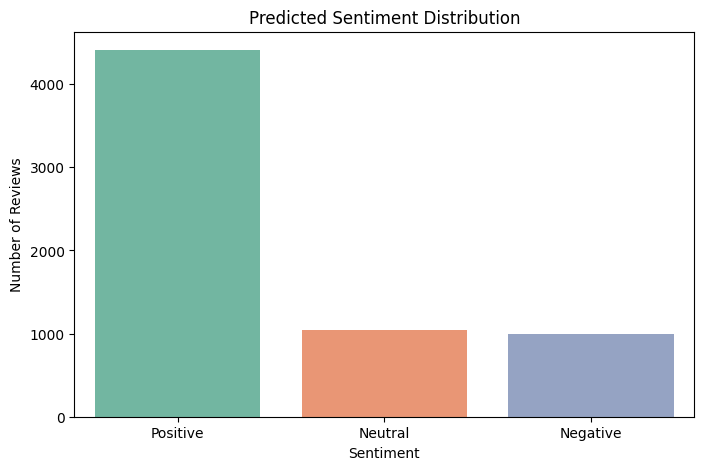

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load predictions CSV
pred_df = pd.read_csv("/content/drive/MyDrive/amazon_reviews_predictions.csv")

# Plot distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Predicted_Sentiment', data=pred_df, palette='Set2')
plt.title("Predicted Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()


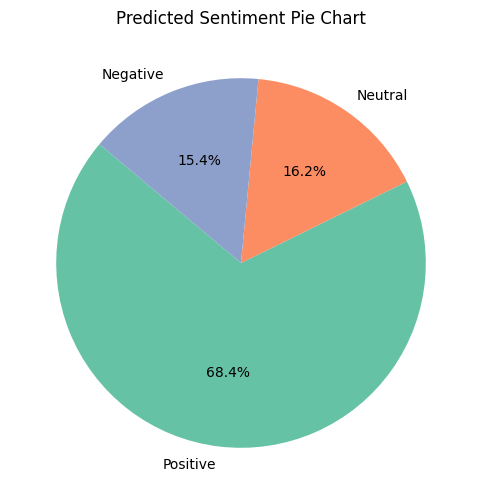

In [ ]:
# Pie chart
sentiment_counts = pred_df['Predicted_Sentiment'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
plt.title("Predicted Sentiment Pie Chart")
plt.show()
